# Logistic regression with MNIST

## Libraries

In [1]:
# libraries
using Flux              # the julia ml library
using Images            # image processing and machine vision for julia
using MLJ               # make_blobs, rmse, confmat, f1score, coerce
using MLDataUtils       # label, nlabel, labelfreq
using MLDatasets        # mnist

using LinearAlgebra     # pinv pseudo-inverse matrix
using Metrics           # r2-score
using Random
using StatsBase         # standardize (normalization)
using Distributions

using Plots; gr()
using StatsPlots
using Printf

using CSV
using DataFrames


## Functions

In [2]:
# functions for feature extraction
meanIntensity(img) = mean(Float64.(img))

function hSymmetry(img)
    imgFloat = Float64.(img)
    imgReverse = reverse(imgFloat, dims=1)
    return -mean( abs.(imgFloat - imgReverse) )
end

hSymmetry (generic function with 1 method)

In [3]:
# lib functions
image2Vector(M) = vec(Float64.(M))

function batchImage2Vector(imagesArray3D)
    h, v, N = size(imagesArray3D)
    vectorOfImageVectors = [ image2Vector( imagesArray3D[:, :, i] ) for i in 1:N]
end

vector2Image(vec, h, v) = reshape(Float64.(vec), (h, v))

function rescaleByColumns(X)
    # using StatsBase
    X = Float64.(X)
    dt = StatsBase.fit(ZScoreTransform, X; dims=1, center=true, scale=true)
    rescaledX = StatsBase.transform(dt, X)
end


rescaleByColumns (generic function with 1 method)

## Data loading

,,,,

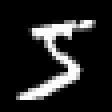
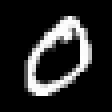
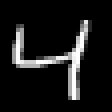
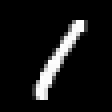
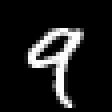

1×5 adjoint(::Vector{Int64}) with eltype Int64:
 5  0  4  1  9

In [4]:
# load mnist from MLDatasets
trainX_original,      trainY_original      = MNIST.traindata()
validationX_original, validationY_original = MNIST.testdata();

display([MNIST.convert2image(MNIST.traintensor(i)) for i in 1:5])
trainY_original[1:5]'

In [5]:
# split trainset, testset, validation set
Random.seed!(1)
(trainX, trainY), (testX, testY) = stratifiedobs((trainX_original, trainY_original), p = 0.7)
validationX = copy(validationX_original); validationY = copy(validationY_original)

size(trainX), size(testX), size(validationX)

((28, 28, 42001), (28, 28, 17999), (28, 28, 10000))

## Data preprocessing

Data preprocessing depends on the data source, thus can widely vary from what is shown here.

In [6]:
# convert images to vectors
trainX = batchImage2Vector(trainX)
trainX[1:5]

5-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [7]:
# select classes for prediction
c = (1, 5)

# data selection from above classes and sizes
trainX = vcat( trainX[trainY .== c[1] ], trainX[ trainY .== c[2] ] )
trainY = vcat( trainY[trainY .== c[1] ], trainY[ trainY .== c[2] ] )

display(levels(trainY))
size(trainX), size(trainY)

2-element Vector{Int64}:
 1
 5

((8514,), (8514,))

In [8]:
# generate predictors and outcome
function generatePredictors(X)
    N = size(X)[1]
    x1 = [meanIntensity(X[i]) for i in 1:N]
    x2 = [hSymmetry(X[i])     for i in 1:N]
    Xs = hcat(x1, x2)
    Xs = rescaleByColumns(Xs)
    
    return Xs
end

trainXLog = generatePredictors(trainX)
trainYLog = copy(trainY);


In [9]:
# specific conversions for model to fit
trainXLog = DataFrame(trainXLog, :auto)
trainYLog = coerce(trainYLog, OrderedFactor);


## Training, Testing, Validation

### Load the algorithm

In [10]:
LogisticClassifier = @load LogisticClassifier pkg=MLJLinearModels verbosity=0

MLJLinearModels.LogisticClassifier

### Instantiate the model

In the context of MLJ, "model" means just a container for hyper parameters.

It is worth to note the output of the below command line, which is a list of the actual values assigned for each hyper parameters, including the default ones. This information can be useful, for exemple, for tuning the parameter at a later stage.

In [11]:
model = LogisticClassifier()

LogisticClassifier(
    lambda = 1.0,
    gamma = 0.0,
    penalty = :l2,
    fit_intercept = true,
    penalize_intercept = false,
    scale_penalty_with_samples = true,
    solver = nothing)

### Creates a machine

In MLJ, "machine" means an object with all learning parameters (i.e. hyper parameters + trainset).

In [12]:
mach = MLJ.machine(model, trainXLog, trainYLog)

Machine{LogisticClassifier,…} trained 0 times; caches data
  model: MLJLinearModels.LogisticClassifier
  args: 
    1:	Source @934 ⏎ `Table{AbstractVector{ScientificTypesBase.Continuous}}`
    2:	Source @197 ⏎ `AbstractVector{OrderedFactor{2}}`


### Train the machine

The machine (or model) is trained according to the programmed hyper parameters and dataset:

In [13]:
fit!(mach,
    # acceleration = CPUThreads(),   # https://alan-turing-institute.github.io/MLJ.jl/v0.7/acceleration_and_parallelism/
    verbosity=2)

┌ Info: Training Machine{LogisticClassifier,…}.
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/CglMw/src/machines.jl:464


Machine{LogisticClassifier,…} trained 1 time; caches data
  model: MLJLinearModels.LogisticClassifier
  args: 
    1:	Source @934 ⏎ `Table{AbstractVector{ScientificTypesBase.Continuous}}`
    2:	Source @197 ⏎ `AbstractVector{OrderedFactor{2}}`


After training, one can inspect the learning parameters:

In [14]:
fitted_params(mach)

(classes = CategoricalArrays.CategoricalValue{Int64, UInt32}[1, 5],
 coefs = [:x1 => 0.22327300773694728, :x2 => -0.27803815922822733],
 intercept = -0.22368399037741235,)

Everything else, if any, the developer might be interested in, can be accesses from the training report:

In [15]:
report(mach)

()

### Predict an outcome

The trained machine/model, stored in the object created for that purpose, is now used to predict the outcome for the trainset:

In [16]:
p = MLJ.predict(mach, trainXLog);


We can inspect a few rows of the prediction, then just a single row.

In [17]:
display(p[1:5])
p[1]

5-element CategoricalDistributions.UnivariateFiniteArray{OrderedFactor{2}, Int64, UInt32, Float64, 1}:
 UnivariateFinite{OrderedFactor{2}}(1=>0.633, 5=>0.367)
 UnivariateFinite{OrderedFactor{2}}(1=>0.704, 5=>0.296)
 UnivariateFinite{OrderedFactor{2}}(1=>0.698, 5=>0.302)
 UnivariateFinite{OrderedFactor{2}}(1=>0.632, 5=>0.368)
 UnivariateFinite{OrderedFactor{2}}(1=>0.647, 5=>0.353)

         UnivariateFinite{OrderedFactor{2}}     
     ┌                                        ┐ 
   1 ┤■■■■■■■■■■■■■■■■■■■■ 0.6330328095306961   
   5 ┤■■■■■■■■■■■■ 0.36696719046930387          
     └                                        ┘ 

For this particular model, the prediction is represented as probabilities for each of the classes. To translate that as the most likely class, we have:

In [18]:
ŷ = predict_mode(mach, trainXLog)
ŷ[1:5]

5-element CategoricalArrays.CategoricalArray{Int64,1,UInt32}:
 1
 1
 1
 1
 1

We can also extract relevant metrics as in the below example:

In [19]:
# metrics
display(confmat(ŷ, trainYLog))
println("accuracy: ", accuracy(ŷ, trainYLog))
println("f1-score: ", f1score(ŷ, trainYLog))

              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │      5      │
├─────────────┼─────────────┼─────────────┤
│      1      │    4651     │    1281     │
├─────────────┼─────────────┼─────────────┤
│      5      │     68      │    2514     │
└─────────────┴─────────────┴─────────────┘


accuracy: 0.8415550857411322
f1-score: 0.7884585228163713


### Evaluate the model

(in progress)

In [20]:
MLJ.evaluate!(mach,
    resampling=CV(nfolds=10),
    measures=[f1score])


Evaluating over 10 folds: 100%[=========================] Time: 0:00:02


PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌───────────────────────────────┬─────────────┬──────────────┬──────────────────
│ measure                       │ measurement │ operation    │ per_fold        ⋯
├───────────────────────────────┼─────────────┼──────────────┼──────────────────
│ FScore(β = 1.0,rev = nothing) │ 0.32        │ predict_mode │ [0.0, 0.0, 0.0, ⋯
└───────────────────────────────┴─────────────┴──────────────┴──────────────────
                                                                1 column omitted


In [21]:
fitted_params(mach)

(classes = CategoricalArrays.CategoricalValue{Int64, UInt32}[1, 5],
 coefs = [:x1 => 0.21582891595986833, :x2 => -0.27099403237588676],
 intercept = -0.44226698487929345,)

In [22]:
ŷ = predict_mode(mach, trainXLog)

display(confmat(ŷ, trainYLog))
println("accuracy: ", accuracy(ŷ, trainYLog))
println("f1-score: ", f1score(ŷ, trainYLog))

              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │      5      │
├─────────────┼─────────────┼─────────────┤
│      1      │    4701     │    2168     │
├─────────────┼─────────────┼─────────────┤
│      5      │     18      │    1627     │
└─────────────┴─────────────┴─────────────┘


accuracy: 0.7432464176650223
f1-score: 0.5981617647058823


### Testing

### Validation

## Demonstration of the prediction

By pressing ENTER at the below cell several times, a randomly chosen slice of the actual outcome is compared to a correspondent slice of the predicted outcome. Due to the accuracy < 1 for the model, some of them will not match.